# Modelverse Interfacing with external service (LoLA)

In this notebook, we will show how to use LoLA as an external service for Petri Net reachability analysis.
LoLA will also return the path indicating how to reach the offending state, which we will also visualize as a model.

## Initialization

First we initialize the Modelverse as usual by importing the wrapper and logging in as some user (in our case the "admin" user).

In [1]:
import sys
sys.path.append("../wrappers/")
from modelverse import *
init()
login(None, None)

from IPython.display import SVG, display

def view(model_name):
    svg = SVG()
    svg.data = show(model_name)
    display(svg)

## Adding metamodels

Add the PetriNets metamodel and show it.

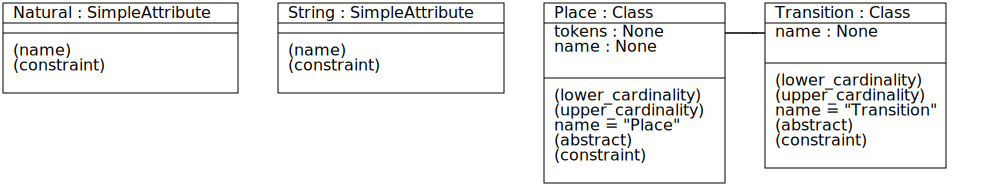

In [2]:
model_add("~/formalisms/PetriNets", "formalisms/SimpleClassDiagrams", """
    SimpleAttribute Natural {}
    SimpleAttribute String {}

    Class Place {
        name = "Place"
        tokens : Natural
        name : String
    }
    Class Transition {
        name = "Transition"
        name : String
    }
    Association P2T (Place, Transition) {
        name = "P2T"
        weight : Natural
    }
    Association T2P (Transition, Place) {
        name = "T2P"
        weight : Natural
    }
    """)
view("~/formalisms/PetriNets")

Add the Query metamodel and show it.

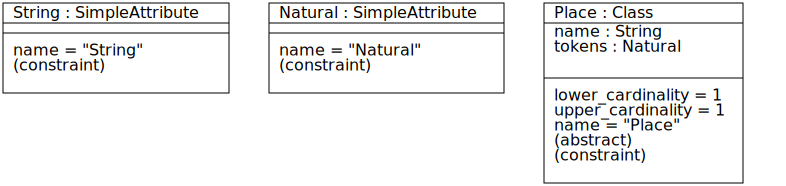

In [3]:
model_add("~/formalisms/Query", "formalisms/SimpleClassDiagrams", """
    include "primitives.alh"
    include "object_operations.alh"
    include "modelling.alh"

    SimpleAttribute String {
        name = "String"
    }
    SimpleAttribute Natural {
        name = "Natural"
    }

    Class Place {
        name = "Place"
        name : String
        tokens : Natural
        lower_cardinality = 1
        upper_cardinality = 1
    }
    """)
view("~/formalisms/Query")

Add the PetriNets execution path formalism and show it.

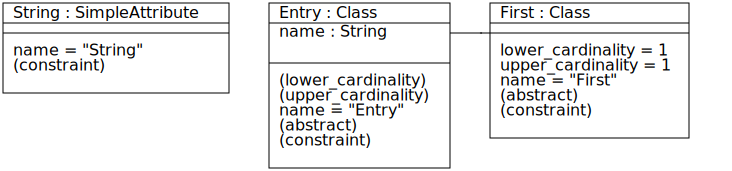

In [4]:
model_add("~/formalisms/PNPath", "formalisms/SimpleClassDiagrams", """
    SimpleAttribute String {
        name = "String"
    }
    
    Class Entry {
        name = "Entry"
        name : String
    }
    
    Class First : Entry {
        name = "First"
        lower_cardinality = 1
        upper_cardinality = 1
    }
    
    Association Next (Entry, Entry){
        source_upper_cardinality = 1
        target_upper_cardinality = 1
    }
    """)
view("~/formalisms/PNPath")

Add the reachability analysis code, relying on the LoLA service.
This code basically only has to serialize the PetriNets and Query model in LoLA format, and then forwards it.
Upon receiving a response from the service, the reachable path is serialized to its own model, which can be used however the user wants.

In [5]:
transformation_add_AL({"PN": "~/formalisms/PetriNets", "Query": "~/formalisms/Query"}, {"Path": "~/formalisms/PNPath"}, "~/models/analyze_lola", """
include "primitives.alh"
include "modelling.alh"
include "object_operations.alh"
include "services.alh"

Boolean function lola_format(model : Element):
    Element all_places
    String place
    String name
    Integer tokens
    String transition
    Element all_transitions
    Element associations
    Element association
    String weight
    String lola_net
    String query
    String place_output
    String marking_output
    String transition_output
    String outp

    all_places = allInstances(model, "PN/Place")
    place_output = "PLACE "
    marking_output = "MARKING "
    while (set_len(all_places) > 0):
        place = set_pop(all_places)
        name = read_attribute(model, place, "name")
        tokens = read_attribute(model, place, "tokens")

        place_output = string_join(place_output, name)

        if tokens > 0:
            if marking_output != "MARKING ":
                marking_output = string_join(marking_output, ", ")
            marking_output = string_join(marking_output, name)
            marking_output = string_join(marking_output, ": ")
            marking_output = string_join(marking_output, cast_string(tokens))
    
        if list_len(all_places) == 0:
            place_output = string_join(place_output, ";")
            marking_output = string_join(marking_output, ";")
        else:
            place_output = string_join(place_output, ", ")

    lola_net = string_join(place_output, marking_output)

    all_transitions = allInstances(model, "PN/Transition")
    transition_output = ""
    while (set_len(all_transitions) > 0):
        transition = set_pop(all_transitions)
        name = read_attribute(model, transition, "name")

        transition_output = string_join(transition_output, " TRANSITION ")
        transition_output = string_join(transition_output, name)
        transition_output = string_join(transition_output, " CONSUME ")

        associations = allIncomingAssociationInstances(model, transition, "PN/P2T")
        while (set_len(associations) > 0):
            association = set_pop(associations)
            place = readAssociationSource(model, association)
            weight = read_attribute(model, association, "weight")
            if cast_integer(weight) > 0:
                transition_output = string_join(transition_output, read_attribute(model, place, "name"))
                transition_output = string_join(transition_output, ": ")
                transition_output = string_join(transition_output, weight)

            if list_len(associations) == 0:
                transition_output = string_join(transition_output, ";")
            else:
                transition_output = string_join(transition_output, ", ")

        transition_output = string_join(transition_output, " PRODUCE ")

        associations = allOutgoingAssociationInstances(model, transition, "PN/T2P")
        while (set_len(associations) > 0):
            association = set_pop(associations)
            place = readAssociationDestination(model, association)
            weight = read_attribute(model, association, "weight")
            if cast_integer(weight) > 0:
                transition_output = string_join(transition_output, read_attribute(model, place, "name"))
                transition_output = string_join(transition_output, ": ")
                transition_output = string_join(transition_output, weight)

            if list_len(associations) == 0:
                transition_output = string_join(transition_output, ";")
            else:
                transition_output = string_join(transition_output, ", ")

    lola_net = string_join(lola_net, transition_output)

    all_places = allInstances(model, "Query/Place")
    if set_len(all_places) > 0:
        place = set_pop(all_places)
        name = read_attribute(model, place, "name")
        tokens = read_attribute(model, place, "tokens")
        query = string_join(name, ' = ')
        query = string_join(query, cast_string(tokens))

    outp = string_join("{\\"petrinet\\":\\"", lola_net)
    outp = string_join(outp, "\\" , \\"query\\":\\"")
    outp = string_join(outp, query)
    outp = string_join(outp, "\\"}")
    
    String port
    port = comm_connect("lola")
    comm_set(port, outp)

    String result
    String path
    result = comm_get(port)
    path = comm_get(port)
    
    Element path_elements
    String first
    String elem
    String prev
    path_elements = string_split(path, ",")
    if (list_len(path_elements) > 0):
        first = instantiate_node(model, "Path/First", "")
        prev = first
        instantiate_attribute(model, first, "name", list_pop(path_elements, 0))
        while (list_len(path_elements) > 0):
            elem = instantiate_node(model, "Path/Entry", "")
            instantiate_attribute(model, elem, "name", list_pop(path_elements, 0))
            instantiate_link(model, "Path/Next", "", prev, elem)
            prev = elem
    
    comm_close(port)

    return cast_boolean(result)!
    """)

## Add models under test

Add a simple Petri Nets model to test with.

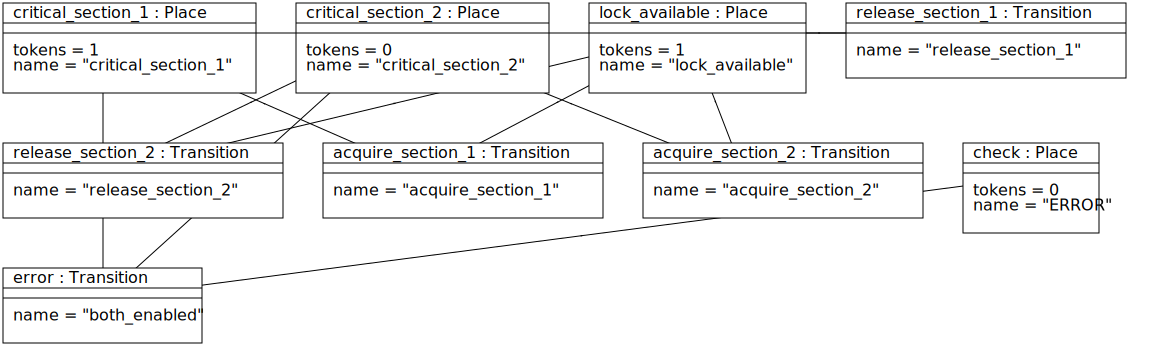

In [6]:
model_add("~/models/PN", "~/formalisms/PetriNets", """
    Place critical_section_1 {
        tokens = 1
        name = "critical_section_1"
    }
    Place critical_section_2 {
        tokens = 0
        name = "critical_section_2"
    }
    Place lock_available {
        tokens = 1
        name = "lock_available"
    }

    Transition release_section_1 {
        name = "release_section_1"
    }
    Transition release_section_2 {
        name = "release_section_2"
    }
    Transition acquire_section_1 {
        name = "acquire_section_1"
    }
    Transition acquire_section_2 {
        name = "acquire_section_2"
    }

    P2T (critical_section_1, release_section_1) {
        weight = 1
    }

    P2T (critical_section_2, release_section_2) {
        weight = 1
    }

    P2T (lock_available, acquire_section_1) {
        weight = 1
    }

    P2T (lock_available, acquire_section_2) {
        weight = 1
    }

    T2P (release_section_1, lock_available) {
        weight = 1
    }

    T2P (release_section_2, lock_available) {
        weight = 1
    }

    T2P (acquire_section_1, critical_section_1) {
        weight = 1
    }

    T2P (acquire_section_2, critical_section_2) {
        weight = 1
    }

    Place check {
        tokens = 0
        name = "ERROR"
    }
    Transition error {
        name = "both_enabled"
    }
    P2T (critical_section_1, error) {
        weight = 1
    }
    P2T (critical_section_2, error) {
        weight = 1
    }
    T2P (error, check) {
        weight = 1
    }
    """)
view("~/models/PN")

Add a simple Query model to check whether it is reachable or not, and subsequently show it.

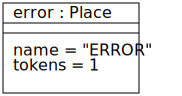

In [7]:
model_add("~/models/Query", "~/formalisms/Query", """
    Place error {
        name = "ERROR"
        tokens = 1
    }
    """)
view("~/models/Query")

## Execution

Finally, we actually invoke the activity, thereby visualizing the error path if applicable.

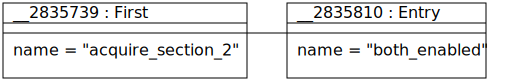

In [8]:
transformation_execute_AL("~/models/analyze_lola", {"PN": "~/models/PN", "Query": "~/models/Query"}, {"Path": "~/models/Path"})
view("~/models/Path")